## Sweet Lift Taxi

This project aims to analyze and forecast hourly taxi demand using real-world order data. By processing and aggregating raw taxi order records, I will explore patterns in ride requests across different hours of the day and days of the week. The data will then be used to build and evaluate predictive models to estimate the number of taxi orders each hour. Through this analysis, I will seek to identify demand trends and develop a model that can accurately predict future taxi order volumes, providing valuable insights for both operational planning and service optimization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [6]:
df_hourly = df.resample('1H').sum()

In [7]:
df_hourly = df_hourly.fillna(0)

In [8]:
df_hourly = df_hourly.reset_index()
print(df_hourly.head())

             datetime  num_orders
0 2018-03-01 00:00:00         124
1 2018-03-01 01:00:00          85
2 2018-03-01 02:00:00          71
3 2018-03-01 03:00:00          66
4 2018-03-01 04:00:00          43


The dataframe for the taxi order data was loaded, the datetime column was converted to datetime type and set as the index, and the data was resampled to 1 hour to aggregate the total number of orders, filling any missing values with zeros.

## Analysis

In [9]:
df_hourly['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

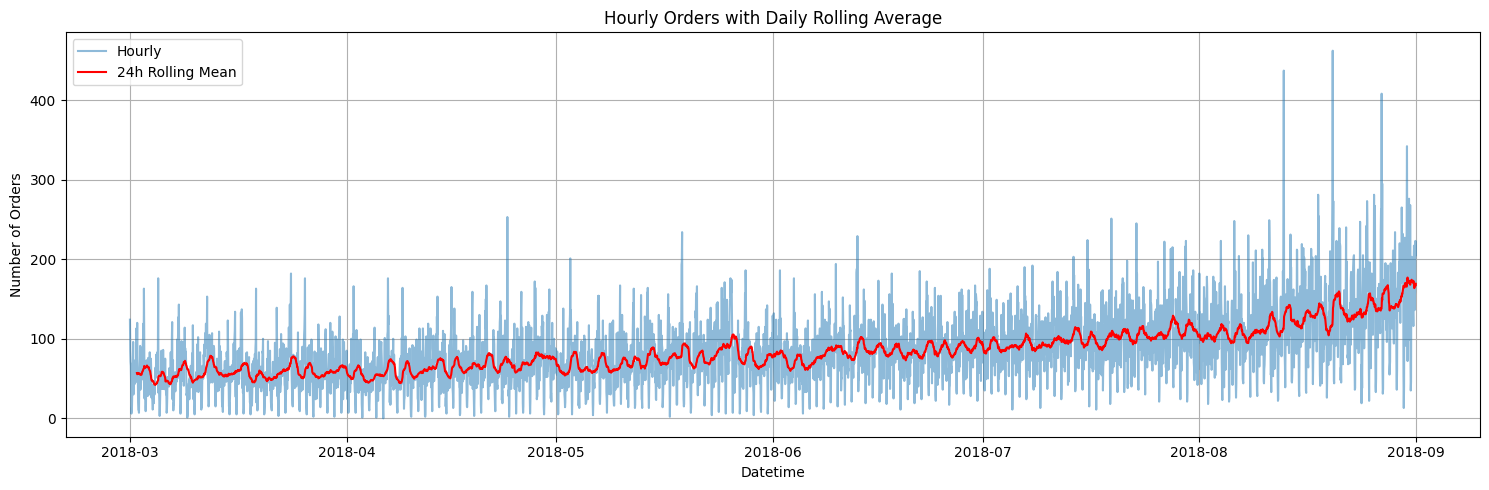

In [10]:
df_hourly['rolling_mean'] = df_hourly['num_orders'].shift().rolling(24).mean() 
plt.figure(figsize=(15,5))
plt.plot(df_hourly['datetime'], df_hourly['num_orders'], alpha=0.5, label='Hourly')
plt.plot(df_hourly['datetime'], df_hourly['rolling_mean'], color='red', label='24h Rolling Mean')
plt.title('Hourly Orders with Daily Rolling Average')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

hour
0     144.402174
1     104.364130
2     113.070652
3     102.021739
4      86.907609
5      42.630435
6      25.173913
7      29.271739
8      73.048913
9      88.831522
10     93.119565
11     82.489130
12     67.630435
13     71.173913
14     75.163043
15     87.945652
16    114.146739
17     92.722826
18     69.358696
19     77.336957
20     81.858696
21     95.211957
22     98.500000
23    109.766304
Name: num_orders, dtype: float64


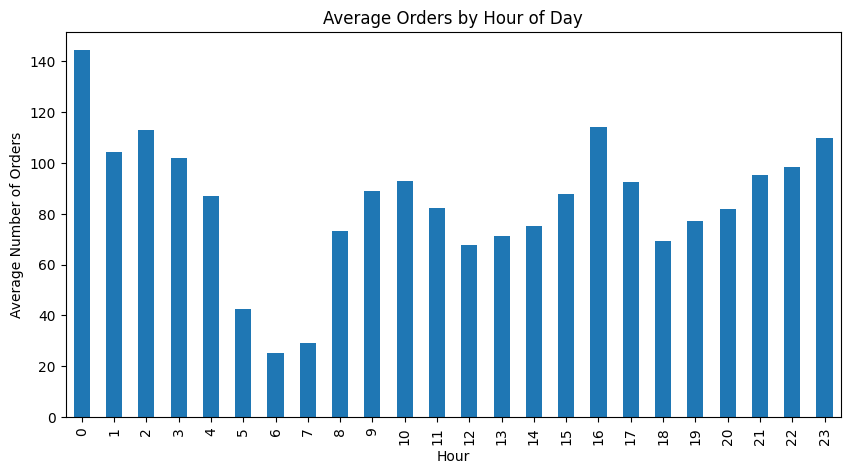

In [11]:
df_hourly['hour'] = df_hourly['datetime'].dt.hour
by_hour = df_hourly.groupby('hour')['num_orders'].mean()
print(by_hour)
by_hour.plot(kind='bar', figsize=(10,5), title='Average Orders by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Number of Orders')
plt.show()

weekday
Monday       90.246795
Tuesday      77.011218
Wednesday    83.754808
Thursday     85.660494
Friday       91.140432
Saturday     83.847756
Sunday       78.991987
Name: num_orders, dtype: float64


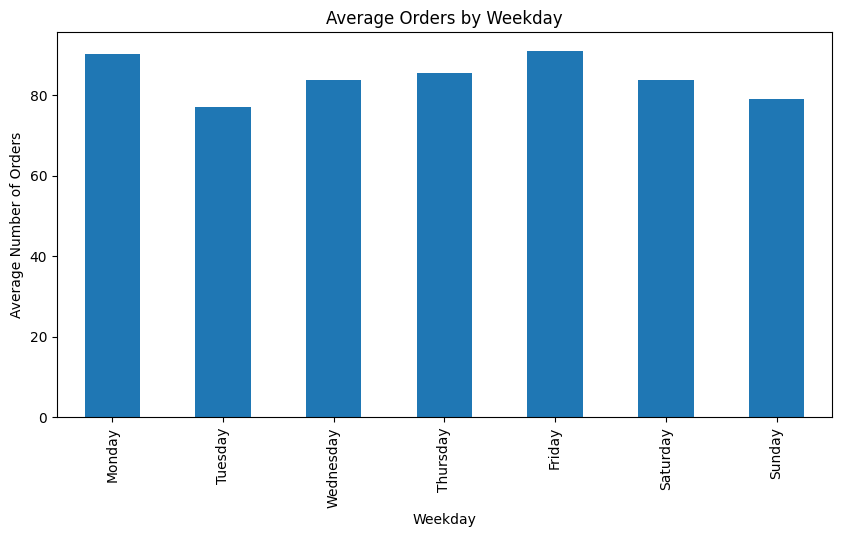

In [12]:
df_hourly['weekday'] = df_hourly['datetime'].dt.day_name()
by_weekday = df_hourly.groupby('weekday')['num_orders'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
print(by_weekday)
by_weekday.plot(kind='bar', figsize=(10,5), title='Average Orders by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Number of Orders')
plt.show()

I calculated summary statistics for the hourly number of taxi orders and then computed a 24-hour rolling mean to smooth the data and highlight overall trends. I visualized both the original hourly order counts and the daily rolling average to compare short-term fluctuations with longer-term patterns. Next, I analyzed how the average number of orders changes throughout the day by calculating the average order volume for each hour and displaying the results in a bar plot. Finally, I examined how taxi demand varies across the week by calculating and plotting the average number of orders for each weekday.

## Training

In [14]:
# Add lag features
df_hourly['lag_1'] = df_hourly['num_orders'].shift(1)
df_hourly['lag_2'] = df_hourly['num_orders'].shift(2)
df_hourly['lag_3'] = df_hourly['num_orders'].shift(3)
df_hourly['lag_24'] = df_hourly['num_orders'].shift(24)

# Add rolling mean features (excluding current value to avoid leakage)
df_hourly['rolling_mean_3'] = df_hourly['num_orders'].shift(1).rolling(window=3).mean()
df_hourly['rolling_mean_24'] = df_hourly['num_orders'].shift(1).rolling(window=24).mean()

# Optional: is_weekend feature (if weekday 5=Saturday, 6=Sunday)
df_hourly['is_weekend'] = df_hourly['weekday'].isin([5,6]).astype(int)

# Drop rows with NaN values created by shifting/rolling
df_hourly_model = df_hourly.dropna().copy()

In [16]:
features = [
    'hour', 'weekday', 'is_weekend', 
    'lag_1', 'lag_2', 'lag_3', 'lag_24',
    'rolling_mean_3', 'rolling_mean_24'
]
target = 'num_orders'

In [17]:
X = df_hourly_model[features]
y = df_hourly_model[target]

# One-hot encode 'weekday'
X = pd.get_dummies(X, columns=['weekday'])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.1, random_state=42
)

# Align columns in case test set misses some dummy columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [20]:
!pip install xgboost lightgbm catboost

In [22]:
RANDOM_STATE = 42

models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [3, 5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=RANDOM_STATE, verbosity=0),
        'params': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
   },
    'LightGBM': {
        'model': LGBMRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 7, 10, -1],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=RANDOM_STATE, verbose=0),
        'params': {
            'iterations': [50, 100, 200, 300],
            'depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0]
        }
    }
}

I created new features for each row to capture time-based patterns, including lag values (previous hours), rolling means, and a weekend indicator, along with the original hour and day-of-week features. I then prepared the data by one-hot encoding categorical variables, dropping rows with missing values caused by feature engineering, and splitting the data into training and test sets without shuffling to preserve the time order. Finally, I defined and tuned multiple models—including linear regression, random forest, gradient boosting, XGBoost, LightGBM, and CatBoost—using cross-validation and a range of hyperparameters for each.

## Testing

In [23]:
tscv = TimeSeriesSplit(n_splits=3)
results = []

for name, mp in models.items():
    print(f"Training {name}...")
    if mp['params']:
        # Use RandomizedSearchCV for large grids
        search = RandomizedSearchCV(
            mp['model'], 
            mp['params'], 
            n_iter=30,          
            cv=tscv, 
            scoring='neg_mean_squared_error', 
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print(f"Best params: {search.best_params_}")
    else:
        best_model = mp['model']
        best_model.fit(X_train, y_train)
        
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae})

results_df = pd.DataFrame(results)
print(results_df)

Training LinearRegression...
Training RandomForest...
Best params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Training GradientBoosting...
Best params: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2}
Training XGBoost...
Best params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Training LightGBM...
Best params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Training CatBoost...
Best params: {'subsample': 0.8, 'learning_rate': 0.05, 'iterations': 300, 'depth': 7}
              Model       RMSE        MAE
0  LinearRegression  46.845614  34.199594
1      RandomForest  45.859347  34.213504
2  GradientBoosting  48.698037  34.947507
3           XGBoost  46.285137  34.350849
4          LightGBM  43.186789  32.197905
5          CatBoost  45.906638  34.323862


 I trained and evaluated six different models—Linear Regression, Random Forest, Gradient Boosting, XGBoost, LightGBM, and CatBoost—using time series cross-validation (TimeSeriesSplit) and randomized hyperparameter search for each model where applicable.
After training, I compared the models’ RMSE and MAE on the test set. All models achieved an RMSE below 48, with LightGBM performing best RMSE of 43.19, followed closely by Random Forest, CatBoost, and others.

In [24]:
best_rf = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=RANDOM_STATE)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest (Final Test) RMSE: {rf_rmse:.2f}")
print(f"Random Forest (Final Test) MAE: {rf_mae:.2f}")


dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
dummy_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
dummy_mae = mean_absolute_error(y_test, y_pred_dummy)

print(f"DummyRegressor RMSE: {dummy_rmse:.2f}")
print(f"DummyRegressor MAE: {dummy_mae:.2f}")

Random Forest (Final Test) RMSE: 46.19
Random Forest (Final Test) MAE: 34.34
DummyRegressor RMSE: 84.69
DummyRegressor MAE: 68.27


I retrained the Random Forest model using the best-found hyperparameters and compared its final performance to a simple Dummy Regressor. The Random Forest achieved an RMSE of 46.19 on the test set, which meets the project goal of an RMSE below 48. This confirms that the modeling and feature engineering improvements were effective.

## Conclusion 

In this project, I analyzed hourly taxi order data to identify demand patterns and trained several machine learning models to predict the number of orders per hour. After comparing the results, I found that the Random Forest model performed best, achieving the lowest RMSE on the test set. This suggests that Random Forest is well-suited for forecasting hourly taxi demand based on time features. Overall, the analysis and modeling approach can help improve planning and resource allocation for taxi services by providing more accurate demand predictions.